# BERT

**Idea of BERT:**
* takes in tokenized and encoded sentences
* goes through the pretrained transformer
* classifies

**What we are using BERT for:**
* take in documents
* outputs a classifier vector
* input the vector into a deep learning or LSTM model for scoring


BERT uses encoder portion of a transformer that can understand context between words. unlike traditional LSTM models they read in one direction, BERT reads in no direction; takes neighbouring words to understand context. **Output** n vectors of size hidden_size(768 in BERT Base), but of the n vectors we only want the 1st vector for classification or the CLS token. With the CLS token we can feed it into a deep learning or other models to predict scores

**Kok Tong’s Notes:
BERT:**
* The BERT model had another layer on top using the BertForSequenceClassifier where we set number_of_labels = 1 (aka continuous variables)
* Might need to add a small number to scores for essay_3 to essay_8
* BERT was able to output a continuous score (but i believe it doesn’t factor in max or min score)
    * So far I’ve implemented bert for first 510 tokens (2min 30 sec runtime)
            * Essay_1 - MSE: 1.4385
            * Essay_2 - MSE: 0.2965
            * Essay_3 - MSE: 0.3770
            * Essay_4 - MSE: 0.2641
            * Essay_5 - MSE: 0.2901
            * Essay_6 - MSE: 0.2847
            * Essay_7 - MSE: 51.5086 ([BAD]|ISSUE!: continuous predictions) ~ 40% accuracy
            * Essay_8 - MSE: 913.6233([BAD]|ISSUE!: continuous predictions)
* So it seems like Essay_1 - Essay_6 are discrete scores while Essay_7 - Essay_8 are continuous and it was really bad
* Might need another method for Essay_7 and Essay_8 maybe explore freezing layers? not too sure what that is 


In [1]:
import pandas as pd
#need to install transformer package
from transformers import DistilBertTokenizer, BertTokenizer

# https://albertauyeung.github.io/2020/06/19/bert-tokenization.html
# https://towardsdatascience.com/bert-to-the-rescue-17671379687f
# https://pdfs.semanticscholar.org/67e2/f470f99e349831f6ff55d4ff6a62b71bc4eb.pdf
# https://medium.com/naukri-engineering/text-classification-using-bert-sklearn-and-pytorch-7665433b56c7
# more info as above https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb
# https://www.reddit.com/r/LanguageTechnology/comments/f2o3ty/has_anyone_used_transformer_models_to_predict/
# https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
# just copy the location of the dataset folder replace "\" with "/"
# encoding "ANSI" might be for windows not sure

# data = pd.read_csv('C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/dataset/training_set_rel3.tsv', sep='\t', header=0, encoding="ANSI")
data = pd.read_csv('C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/clean_ver-1.csv')

In [4]:
data.head()

,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0


In [5]:
# #Extract the document contents
# #we can probably use loc instead of iloc to
# doc1 = data.iloc[0,2]

In [6]:

# doc1

In [7]:
# # Indicates how many characters are in the document NOT tokens
# len(doc1)

### BERT

So BERT "model" takes in a maximum input tokens of 512 tokens = 510 (word tokens) + 2 (**mandatory special CLS and SEP tokens** ). Since most of our post tokenized documents (without special tokens) exceeds 510 (word tokens), we will need to pre-split the documents perhaps : dataset(doc(first_half, second_half)). After splitting it, we will run BERT and take the output CLS token's vector (size 768) 

In [8]:
# round(1000/510)

In [9]:
data_tokenize = data

data_tokenize["doc_token"] = data_tokenize.loc[:,'essay']


In [10]:
%%time 
#data_tokenise.iloc[:,-1] = tokenizer.tokenize(data_tokenise.iloc[:,-1]) - didnt work


#tokenize words to token
data_tokenize["doc_token"] = data_tokenize.apply(lambda row: tokenizer.tokenize(row['doc_token']), axis=1)

# #tokenize word into id plus CLS (classifier token) and SEP (seperator token)
# data_tokenize["doc_token_id"] = data_tokenize.apply(lambda row: tokenizer.encode(row['essay'], add_special_tokens = True), axis=1)

    
data_tokenize.head()

Wall time: 47.7 s


,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score,doc_token
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, local, newspaper, ,, i, think, effects,..."
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0,"[dear, @, caps, @, caps, ,, i, believe, that, ..."
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0,"[dear, ,, @, caps, @, caps, @, caps, more, and..."
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0,"[dear, local, newspaper, ,, @, caps, i, have, ..."
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, @, location, ,, i, know, having, comput..."


### NOTE:
 Alot of the tokens are longer than the maximum tokens BERT will take >512 so we need to break up the document into multiples of 512 [Not done]

In [11]:
data_tokenize.shape

(12976, 13)

# Change essay set here

In [12]:
data_tokenize['doc_len_raw'] = data_tokenize.loc[:,"doc_token"].apply(lambda x: len(x))

essay_set = data_tokenize.essay_set.unique()
print(essay_set)


# Change essay_set[i] according to which essay- eg: essay 1 : i = 0
essay_sub = data_tokenize.loc[data_tokenize["essay_set"] == essay_set[0], :]

essay_sub.doc_len_raw.max()

[1 2 3 4 5 6 7 8]


1002

In [13]:
import math

math.ceil(essay_sub.doc_len_raw.max()/510)

2

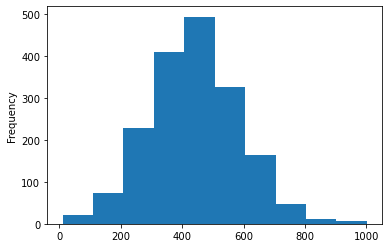

In [14]:
essay_sub.doc_len_raw.plot.hist()

In [15]:
essay_sub.head()

,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score,doc_token,doc_len_raw
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, local, newspaper, ,, i, think, effects,...",418
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0,"[dear, @, caps, @, caps, ,, i, believe, that, ...",494
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0,"[dear, ,, @, caps, @, caps, @, caps, more, and...",319
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0,"[dear, local, newspaper, ,, @, caps, i, have, ...",680
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, @, location, ,, i, know, having, comput...",556


### Preprocessing strategy

we need to split the tokens into post padded and special tokenized of size 512

In [16]:


def split_tok(df_col, num_bert_model):
    
    split_list = []
    start_ix = 0
    end_ix = 510
    len_cell = len(df_col)
    
    # 510 due to the maximum tokens bert model can take in before inducing an error
    for i in range(num_bert_model):
        
#         if end_ix > len_cell:
#             split_list.append(df_col[start_ix:len_cell])
#             start_ix = start_ix + 510
#             end_ix = end_ix + 510
        
        # first bert model with token >510
        if start_ix < len_cell:
            split_list.append(df_col[start_ix:end_ix])
            start_ix = start_ix + 510
            end_ix = end_ix + 510
        
        # cell < 510 | tokens out of end_ix range
        else:
            split_list.append([""])
                
            
        
    return split_list


In [17]:
# this was for testing
# # split_tok(['hello' ,'my', 'name', 'is', 'jeff'], 2)

# test = ['hello' ,'my', 'name', 'is', 'jeff']

# split_list = []
# start_ix = 0
# end_ix = 510
# len_cell = len(test)

# # 510 due to the maximum tokens bert model can take in before inducing an error
# for i in range(2):

# #         if end_ix > len_cell:
# #             split_list.append(df_col[start_ix:len_cell])
# #             start_ix = start_ix + 510
# #             end_ix = end_ix + 510

#     # first bert model with token >510
#     if start_ix < len_cell:
#         split_list.append(test[start_ix:end_ix])
#         start_ix = start_ix + 510
#         end_ix = end_ix + 510
#         print("I was in if")
#     else:
#         split_list.append([''])
#         print("I was in else")
        
# split_list
                



In [18]:
essay_sub.head()

,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score,doc_token,doc_len_raw
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, local, newspaper, ,, i, think, effects,...",418
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0,"[dear, @, caps, @, caps, ,, i, believe, that, ...",494
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0,"[dear, ,, @, caps, @, caps, @, caps, more, and...",319
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0,"[dear, local, newspaper, ,, @, caps, i, have, ...",680
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, @, location, ,, i, know, having, comput...",556


In [19]:
#reset index
essay_sub = essay_sub.reset_index(drop=True)

In [20]:
essay_sub.head()

,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score,doc_token,doc_len_raw
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, local, newspaper, ,, i, think, effects,...",418
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0,"[dear, @, caps, @, caps, ,, i, believe, that, ...",494
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0,"[dear, ,, @, caps, @, caps, @, caps, more, and...",319
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0,"[dear, local, newspaper, ,, @, caps, i, have, ...",680
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, @, location, ,, i, know, having, comput...",556


In [21]:
split_tok(essay_sub.doc_token[0], math.ceil(max(essay_sub.doc_len_raw)/510))

[['dear',
  'local',
  'newspaper',
  ',',
  'i',
  'think',
  'effects',
  'computers',
  'have',
  'on',
  'people',
  'are',
  'great',
  'learning',
  'skills',
  '/',
  'affects',
  'because',
  'they',
  'give',
  'us',
  'time',
  'to',
  'chat',
  'with',
  'friends',
  '/',
  'new',
  'people',
  ',',
  'helps',
  'us',
  'learn',
  'about',
  'the',
  'globe',
  '(',
  'astronomy',
  ')',
  'and',
  'keeps',
  'us',
  'out',
  'of',
  'tr',
  '##ob',
  '##le',
  '!',
  'thing',
  'about',
  '!',
  'don',
  '##t',
  'you',
  'think',
  'so',
  '?',
  'how',
  'would',
  'you',
  'feel',
  'if',
  'your',
  'teenager',
  'is',
  'always',
  'on',
  'the',
  'phone',
  'with',
  'friends',
  '!',
  'do',
  'you',
  'ever',
  'time',
  'to',
  'chat',
  'with',
  'your',
  'friends',
  'or',
  'bu',
  '##is',
  '##ness',
  'partner',
  'about',
  'things',
  '.',
  'well',
  'now',
  '-',
  'there',
  "'",
  's',
  'a',
  'new',
  'way',
  'to',
  'chat',
  'the',
  'computer',
 

In [22]:
essay_sub.doc_token

0       [dear, local, newspaper, ,, i, think, effects,...
1       [dear, @, caps, @, caps, ,, i, believe, that, ...
2       [dear, ,, @, caps, @, caps, @, caps, more, and...
3       [dear, local, newspaper, ,, @, caps, i, have, ...
4       [dear, @, location, ,, i, know, having, comput...
                              ...                        
1778    [dear, @, caps, ,, @, caps, several, reasons, ...
1779    [do, a, adults, and, kids, spend, to, much, ti...
1780    [my, opinion, is, that, people, should, have, ...
1781    [dear, readers, ,, i, think, that, its, good, ...
1782    [dear, -, local, newspaper, i, agree, that, ##...
Name: doc_token, Length: 1783, dtype: object

In [23]:

essay_sub.loc[:,"doc_split"] = essay_sub["doc_token"].apply(lambda x: split_tok(x, math.ceil(max(essay_sub.doc_len_raw)/510)))

In [24]:
# essay_sub[(essay_sub.doc_len_raw > 510)&(essay_sub.doc_len_raw <1020)]

We have split each individual document of essay type 1 to a the correct format for adding special tokens

**Note** : we might need to factor in proportions for the tail of documents since they don't provide much value
* For example: essay type 1 - document length = 520 = list((510), (10)) but the issue is if we add this to bert the tail meaning "10" should not have the same predictive power as the 510 (**Food for thought**)

In [25]:
import transformers
print(transformers.__version__)

3.3.0


In [26]:
# # Encode the sentence
# encoded = tz.encode_plus(
#     text=sent,  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 64,  # maximum length of a sentence
#     pad_to_max_length=True,  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors
# )

In [27]:
def encode_tok(cell, num_bert_model):
    enc_ls = []
    # possible error from setting 512 here
    for i in range(num_bert_model):
        enc_ls.append(tokenizer.encode_plus(text=cell[i], add_special_tokens=True, max_length=512, 
                              pad_to_max_length = True, return_attention_mask=True, return_tensors="pt"))
        
    return enc_ls
        

In [28]:
essay_sub.loc[:,"encoded"] = essay_sub["doc_split"].apply(lambda x: encode_tok(x, math.ceil(max(essay_sub.doc_len_raw)/510)))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\lowkt\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1767: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitely activated but `max_length` is provided a specific value, please

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [29]:
# encoded = tokenizer.encode_plus(
#     text=essay_1.doc_split[0][1],  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 510,  # maximum length of a sentence
#     pad_to_max_length=True,  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors
# )
# encoded

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertConfig, AdamW, DistilBertModel, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [31]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [32]:
# # Split the data into train and test

# X = essay_1.encoded
# y = essay_1.domain1_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30034)

In [33]:
# print(type(X_test[0][0]['input_ids'][0]))
# print(type(X_test[0][0]['attention_mask'][0]))

In [34]:
def ext_first(cell):
    return cell[0]

In [35]:
essay_sub.loc[:,"first_510"] = essay_sub["doc_split"].apply(lambda x: ext_first(x))

In [36]:
essay_sub.head()

,Unnamed: 0,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,total_score,doc_token,doc_len_raw,doc_split,encoded,first_510
0,0,1,1,"Dear local newspaper, I think effects computer...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, local, newspaper, ,, i, think, effects,...",418,"[[dear, local, newspaper, ,, i, think, effects...","[[input_ids, token_type_ids, attention_mask], ...","[dear, local, newspaper, ,, i, think, effects,..."
1,1,2,1,"Dear @CAPS @CAPS, I believe that using compute...",5,4,0.0,9,0.0,0.0,0.0,9.0,"[dear, @, caps, @, caps, ,, i, believe, that, ...",494,"[[dear, @, caps, @, caps, ,, i, believe, that,...","[[input_ids, token_type_ids, attention_mask], ...","[dear, @, caps, @, caps, ,, i, believe, that, ..."
2,2,3,1,"Dear, @CAPS @CAPS @CAPS More and more people u...",4,3,0.0,7,0.0,0.0,0.0,7.0,"[dear, ,, @, caps, @, caps, @, caps, more, and...",319,"[[dear, ,, @, caps, @, caps, @, caps, more, an...","[[input_ids, token_type_ids, attention_mask], ...","[dear, ,, @, caps, @, caps, @, caps, more, and..."
3,3,4,1,"Dear Local Newspaper, @CAPS I have found that ...",5,5,0.0,10,0.0,0.0,0.0,10.0,"[dear, local, newspaper, ,, @, caps, i, have, ...",680,"[[dear, local, newspaper, ,, @, caps, i, have,...","[[input_ids, token_type_ids, attention_mask], ...","[dear, local, newspaper, ,, @, caps, i, have, ..."
4,4,5,1,"Dear @LOCATION, I know having computers has a ...",4,4,0.0,8,0.0,0.0,0.0,8.0,"[dear, @, location, ,, i, know, having, comput...",556,"[[dear, @, location, ,, i, know, having, compu...","[[input_ids, token_type_ids, attention_mask], ...","[dear, @, location, ,, i, know, having, comput..."


In [37]:
# encodes the first 510 tokens
essay_sub.loc[:,"1st_encode"] = essay_sub["first_510"].apply(lambda x: tokenizer.encode_plus(text=x, add_special_tokens=True, max_length=512, pad_to_max_length = True, return_attention_mask=True, return_tensors="pt"))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\lowkt\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1767: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitely activated but `max_length` is provided a specific value, please

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [38]:
ls_input = essay_sub['1st_encode'][0]['input_ids']

In [39]:
ls_input = []
ls_att = []

for cell in essay_sub['1st_encode']:
    ls_input.append(cell["input_ids"].tolist()[0])
    ls_att.append(cell["attention_mask"].tolist()[0])
    

In [40]:
ls_score = essay_sub.domain1_score.to_list()

In [41]:
# # https://towardsdatascience.com/bert-to-the-rescue-17671379687f

# bert = BertModel.from_pretrained('bert-base-uncased')
# x = torch.tensor(train_tokens_ids[:3])
# y, pooled = bert(x, output_all_encoded_layers=False)
# print('x shape:', x.shape)
# print('y shape:', y.shape)
# print('pooled shape:', pooled.shape)
# # OUTPUT
# x shape :(3, 512)
# y shape: (3, 512, 768)
# pooled shape: (3, 768)

In [42]:
# # https://towardsdatascience.com/bert-to-the-rescue-17671379687f
# class BertBinaryClassifier(nn.Module):
#     def __init__(self, dropout=0.1):
#         super(BertBinaryClassifier, self).__init__()

#         self.bert = BertModel.from_pretrained('bert-base-uncased')

#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(768, 1)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, tokens, masks=None):
#         _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         proba = self.sigmoid(linear_output)
#         return proba

In [43]:
# #https://www.reddit.com/r/MLQuestions/comments/e8kyc3/finetuning_bert_for_a_regression_task/
# # didnt really work -- it's so frustrating...

# class Net(nn.Module): 
#     def __init__(self): 
#         super(Net, self).__init__() 
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         # Uncomment below if you wanna freeze bert
#         #for p in self.bert.parameters():
#         #    p.requires_grad = False
#         self.fc0 = nn.Linear(768, 1)
#     def forward(self,x,att,pos): # attention mask, position of [mask] token
#         hidden = self.bert(x,attention_mask=att)[0]
#         net = hidden[torch.arange(hidden.shape[0]),pos,:]
#         net = self.fc0(net)
#         return net

In [44]:
# torch.cuda.empty_cache()

In [45]:
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

In [46]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

We gonna use a basic Bert Model to test out the output

In [47]:
# https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
# min = 2, max = 12 ls_score

# we are going to split data into train, val and test

train_inputs, val_inputs, train_labels, val_labels = train_test_split(ls_input, ls_score,
                                                                     random_state = 30034,
                                                                      test_size = 0.3, shuffle = False)

train_masks, val_masks, _, _ = train_test_split(ls_att, ls_input, random_state = 30034, 
                                               test_size = 0.3, shuffle = False)

# Converts all data into torch tensors for Bert Model

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)

# train_labels = torch.tensor(train_labels, dtype=torch.float32)
# val_labels = torch.tensor(val_labels, dtype=torch.float32)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

# Select Batch size

batch_size = 4

# Create an iterator for data using DataLoader - this to make sure that our system isnt overloaded with data

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler= train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler= val_sampler, batch_size = batch_size)


In [48]:
val_labels.dtype


torch.int64

In [49]:
train_labels[1]

tensor(9)

### Update (18-10-2020):

So since we run into memory issue with the back propogation, I am going to use a plain bert model and run a model on the output of bert, hopefuly it goes well


In [50]:
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 11)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [51]:
# https://github.com/suyash2104/Disaster-detector/blob/master/Bert_model_training.ipynb

optimizer = AdamW(model.parameters(), lr = 1e-5)

In [52]:
%%time
n_epochs = 1

# # Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


# for epoch in range(n_epochs):
#     model.train()
#     for step, batch in enumerate(train_dataloader):
#         batch = tuple(t.to(device) for t in batch)
#         b_input_ids, b_input_mask, b_labels = batch
#         optimizer.zero_grad()
        
#         outputs = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
#         loss = outputs[0]
#         loss.backward()
#         optimizer.step()


# ## Tracking variables
# tr_loss = 0
# nb_tr_examples, nb_tr_steps = 0, 0

## For discrete
model.train()
for epoch in range(n_epochs):
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        
        outputs = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
        loss = outputs[0]
#         loss.backward()
#         optimizer.step()
#         # Update tracking variables
        print("loss: ", loss)
#         tr_loss += loss
#         nb_tr_examples += b_input_ids.size(0)
#         nb_tr_steps += 1
#     print("Train loss: {}".format(tr_loss/nb_tr_steps))

loss:  tensor(2.5535, device='cuda:0', grad_fn=<NllLossBackward>)


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 8.00 GiB total capacity; 6.06 GiB already allocated; 26.97 MiB free; 6.16 GiB reserved in total by PyTorch)

In [53]:
loss
#tensor(82.4472, device='cuda:0', grad_fn=<MseLossBackward>)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

In [ ]:
# torch.save(model.state_dict(), 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/my_model.pt')

In [ ]:

# torch.save(train_inputs, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/train_inputs.pt')
# torch.save(val_inputs, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/val_inputs.pt')
# torch.save(train_labels, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/train_labels.pt')
# torch.save(val_labels, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/val_labels.pt')
# torch.save(train_masks, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/train_masks.pt')
# torch.save(val_masks, 'C:/Users/lowkt/Anaconda Files/Applied Data Science/Final_project_git/MAST30034-FINAL-PROJECT/Word Tokenisations/BERT/val_masks.pt')

In [ ]:
model.eval()

In [ ]:
count = 0
sse = 0
tot_len = 0
acc = 0
pred = []
for step, batch in enumerate(val_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask = b_input_mask, labels = b_labels)
    
    loss = outputs[0]
    reshape_var = outputs[1].size()[0]
    pred.append(outputs[1].reshape(1,reshape_var).tolist())
    count += 1
    sse = sse + sum((b_labels.reshape(reshape_var,1) - outputs[1])**2)
    acc = acc + sum(abs(b_labels.reshape(reshape_var,1) - outputs[1])/b_labels.reshape(reshape_var,1))
    tot_len = tot_len + len(outputs[1])
    print("acc{}: ".format(count), acc)
    print("pred{}: ".format(count), outputs[1])
    print("actual{}: ".format(count), b_labels)
    print("loss{}: ".format(count), loss)

In [ ]:
# MSE
sse/tot_len

In [ ]:
sum((val_labels - train_labels.mean())**2)/tot_len

In [ ]:
sum((val_labels - train_labels.median())**2)/tot_len

In [ ]:
1-acc/tot_len

In [ ]:
acc


In [ ]:
pred[0] 
# val_labels[0]

In [ ]:
prediction_ls = []
for i in pred:
    for pred1 in i:
        for pred2 in pred1:
            prediction_ls.append(pred2)

In [ ]:
actual = val_labels

In [ ]:

actual = val_labels.clone().detach()

In [ ]:
actual.squeeze().tolist()
form_actual = [ round(elem) for elem in actual.squeeze().tolist() ]
form_actual

In [ ]:
prediction_ls
form_pred = [ round(elem) for elem in prediction_ls ]
form_pred

In [ ]:
type(form_pred[0])

In [ ]:
type(actual.squeeze().tolist()[0])

In [ ]:
from sklearn.metrics import cohen_kappa_score
result = cohen_kappa_score(form_actual,form_pred,weights='quadratic')

In [ ]:
result

In [ ]:
prediction_ten = torch.tensor(prediction_ls, dtype=torch.float32)

In [ ]:
prediction_ten.tolist()

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

In [ ]:
essay_sub.domain1_score.plot.hist(title = "Essay Set {} Actual Marks".format(essay_sub.essay_set.unique()[0]))

In [ ]:
essay_sub.essay_set.unique()[0]

In [ ]:
essay_sub.domain1_score.median()